In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torchvision.utils import make_grid

In [2]:
join = os.path.join
base_path = "/home/anmol/projects/pytorch_classification_template/datafolder/saved"

In [3]:
query_path = join(base_path, "query_actv")
val_path = join(base_path, "val_actv")

In [4]:
for file in glob.glob(join(query_path, "*")):
    if "activationMap.pkl" in file:
        query_act = pickle.load(open(file, 'rb'))
    elif "gt.pkl" in file:
        gt_q = pickle.load(open(file, 'rb'))
    elif 'pred.pkl' in file:
        pred_q = pickle.load(open(file, 'rb'))
    else:
        shape_q = pickle.load(open(file, 'rb'))
        
for file in glob.glob(join(val_path, "*")):
    if "activationMap.pkl" in file:
        val_act = pickle.load(open(file, 'rb'))
    elif "gt.pkl" in file:
        gt_v = pickle.load(open(file, 'rb'))
    elif 'pred.pkl' in file:
        pred_v = pickle.load(open(file, 'rb'))
    else:
        shape_v = pickle.load(open(file, 'rb'))

In [5]:
def flatten(t):
    t = t.reshape(t.shape[0], -1)
    t = t.squeeze()
    return t

Shape of the network layers

In [6]:
shape_v

[torch.Size([64, 64, 55, 55]),
 torch.Size([64, 192, 27, 27]),
 torch.Size([64, 384, 13, 13]),
 torch.Size([64, 256, 13, 13]),
 torch.Size([64, 256, 13, 13]),
 torch.Size([64, 4096]),
 torch.Size([64, 4096]),
 torch.Size([64, 2])]

Concatenate network activations into a single vector. For now we use layers {1, 2, 3}. 

In [91]:
def recast_to_flattened(act, layers=None):
    
    if layers is None:
        layers = list(range(len(act.keys())))
        
    for k in layers:
        if k == layers[0]:
            val_im_act_matrix = flatten(act[k])
        else:
            val_im_act_matrix = torch.cat([val_im_act_matrix, 
                                           flatten(act[k])], dim=1)

        print(val_im_act_matrix.shape)
        
    return val_im_act_matrix

In [92]:
val_im_act_matrix = recast_to_flattened(val_act, layers=[0,1,2,3,4])

torch.Size([600, 193600])
torch.Size([600, 333568])
torch.Size([600, 398464])
torch.Size([600, 441728])
torch.Size([600, 484992])


In [93]:
val_im_act_matrix.shape

torch.Size([600, 484992])

In [94]:
def recast_to_network_shape(matrix, shape_v, val_act, binary=False, layers=None):
    """
    This function recasts the flattened activation vector into original shapes
    from which they were flattened. For integrity check, it has an assert statement
    that ensures the un-flattened tensor actually equates the original activation 
    tensor. 
    
    matrix: 2D matrix which contains the flattened activation maps
    shape_v: list containing tensor shapes of layers in network
    val_act: original activations, to ensure integrity
    binary: True if features are just True/False tensors, which came from a feature selection algorithm
            False otherwise
    layers: list of indices of layers that were concatenated
    """
    curr_offset = 0
    SUCCESS = 1
    layer_act = {}
    if layers is None:
        print("Recasting to all layers!")
        layers = list(range(len(shape_v)))
        
    for curr_layer in layers:
        l_shape = shape_v[curr_layer][1:]

        # find the size of flattened vector for this layer
        total_fl_for_this_layer = 1
        for i in l_shape:
            total_fl_for_this_layer *= i
        
        print('Flattened vector size = {} for original shape = {}'.format(total_fl_for_this_layer, l_shape))
        print('Referencing from {} to {}'.format(curr_offset, 
                                                curr_offset+total_fl_for_this_layer))
        layer_act[curr_layer] = matrix[:, curr_offset:curr_offset+total_fl_for_this_layer].view(matrix.shape[0], 
                                                            l_shape[0], 
                                                            l_shape[1], 
                                                            l_shape[2])
        orig_act = val_act[curr_layer]
        curr_offset = curr_offset+total_fl_for_this_layer
        
        if not binary:
            # features are not binary, which means they are real tensors. 
            assert torch.all(torch.eq(orig_act, layer_act[curr_layer])), "Matrices don't match! STOP!"
    
    return layer_act, SUCCESS

In [95]:
layer_act, _s = recast_to_network_shape(val_im_act_matrix, shape_v, val_act, layers=[0,1,2,3,4])

Flattened vector size = 193600 for original shape = torch.Size([64, 55, 55])
Referencing from 0 to 193600
Flattened vector size = 139968 for original shape = torch.Size([192, 27, 27])
Referencing from 193600 to 333568
Flattened vector size = 64896 for original shape = torch.Size([384, 13, 13])
Referencing from 333568 to 398464
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 398464 to 441728
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 441728 to 484992


We now have a matrix with rows M = number of validation images, and columns N = number of neurons (total 204864 for 2 conv layers)

In [96]:
val_im_act_matrix.shape

torch.Size([600, 484992])

In [97]:
gt_v.shape

torch.Size([600])

In [98]:
pred_v.shape

torch.Size([600, 2])

The predictions are NOT SOFTMAX probabilities, so convert them

In [99]:
softmax = nn.Softmax()
pred_v = softmax(pred_v)

/home/anmol/softwares/anaconda3/envs/pt10/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Convert the prediction probabilities to class labels

In [100]:
_, pred_v_cl = torch.max(pred_v, 1)

In [101]:
pred_v

tensor([[0.7311, 0.2689],
        [0.7282, 0.2718],
        [0.5618, 0.4382],
        ...,
        [0.7310, 0.2690],
        [0.4018, 0.5982],
        [0.7127, 0.2873]])

Get the correct and incorrect prediction "ground truth". This ground truth will contain -1 if the image was incorrectly predicted, and +1 if it was correctly predicted. 

In [102]:
new_gt_for_training = torch.ones([pred_v.shape[0]], dtype=torch.int32)
correct = incorrect = 0
for i in range(0, pred_v.shape[0]):
    if pred_v_cl[i] != gt_v[i]:
        incorrect += 1
        new_gt_for_training[i] = -1
    else:
        correct += 1
        new_gt_for_training[i] = 1

In [103]:
print("Correct predictions = {}, incorrect predictions = {}".format(correct, incorrect))

Correct predictions = 459, incorrect predictions = 141


Convert these tensors to numpy for compatibility with sklearn

In [104]:
X = val_im_act_matrix.numpy()
Y = new_gt_for_training.numpy()

We  have the training data now. X and Y. Let's do some machine learning

In [105]:
X.shape

(600, 484992)

In [106]:
Y.shape

(600,)

### Let's do some feature selection

First, remove features that have a very low variance threshold. 

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by:

$Var[X]$ = $p(1-p)$

so we can select using the threshold .8 * (1 - .8):

In [260]:
from sklearn.feature_selection import VarianceThreshold
# sel = VarianceThreshold(threshold=(.95 * (1 - .95)))
sel = VarianceThreshold()
selected_features_from_X = sel.fit_transform(X)

In [261]:
selected_features_from_X.shape

(600, 468441)

In [262]:
selected_support = torch.from_numpy(sel.get_support().astype(np.float32)).view(1, -1)

In [263]:
selected, _s = recast_to_network_shape(selected_support, shape_v, val_act, binary=True, layers=[0,1,2,3,4])

Flattened vector size = 193600 for original shape = torch.Size([64, 55, 55])
Referencing from 0 to 193600
Flattened vector size = 139968 for original shape = torch.Size([192, 27, 27])
Referencing from 193600 to 333568
Flattened vector size = 64896 for original shape = torch.Size([384, 13, 13])
Referencing from 333568 to 398464
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 398464 to 441728
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 441728 to 484992


####  Visualize the selected features in terms of network activations

In [264]:
selected_support.shape

torch.Size([1, 484992])

In [265]:
mean_act = torch.mean(torch.from_numpy(X), dim=0).view(1, -1)
mean_act_l, _s = recast_to_network_shape(mean_act, shape_v, val_act, binary=True, layers=[0,1,2,3,4])

Flattened vector size = 193600 for original shape = torch.Size([64, 55, 55])
Referencing from 0 to 193600
Flattened vector size = 139968 for original shape = torch.Size([192, 27, 27])
Referencing from 193600 to 333568
Flattened vector size = 64896 for original shape = torch.Size([384, 13, 13])
Referencing from 333568 to 398464
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 398464 to 441728
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 441728 to 484992


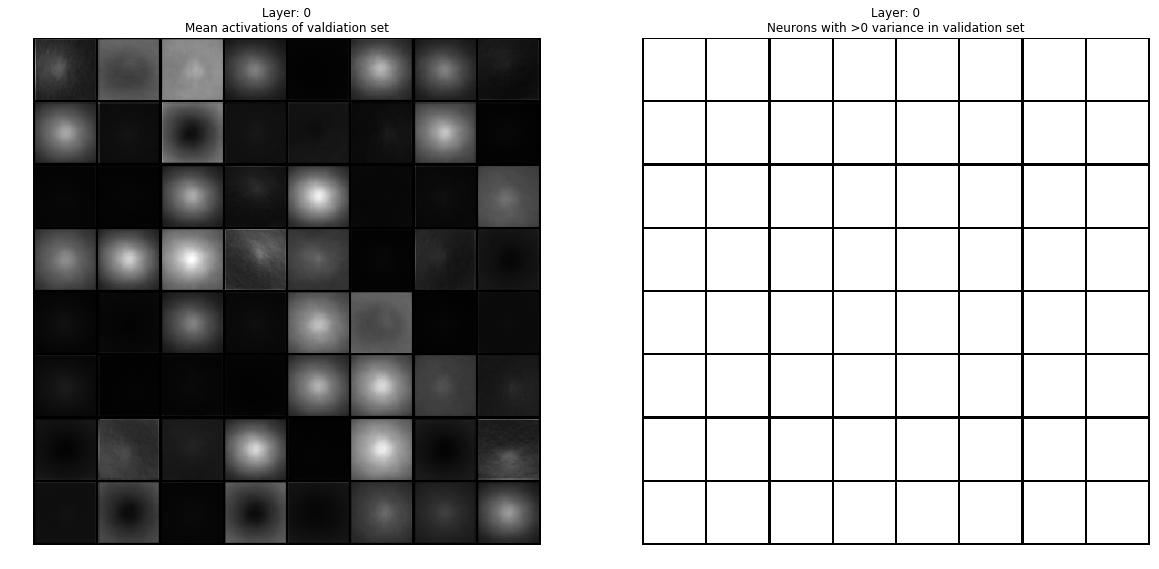

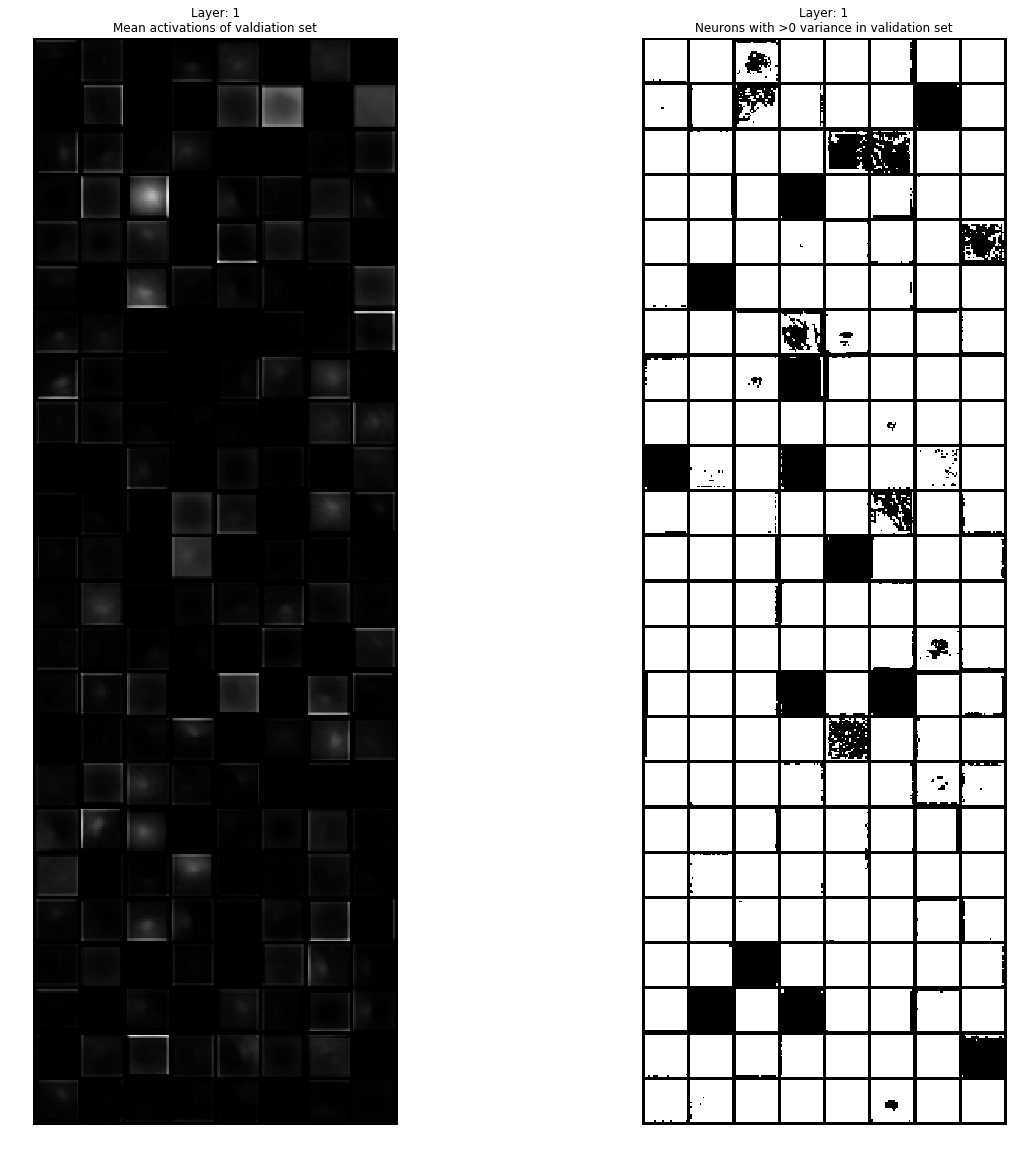

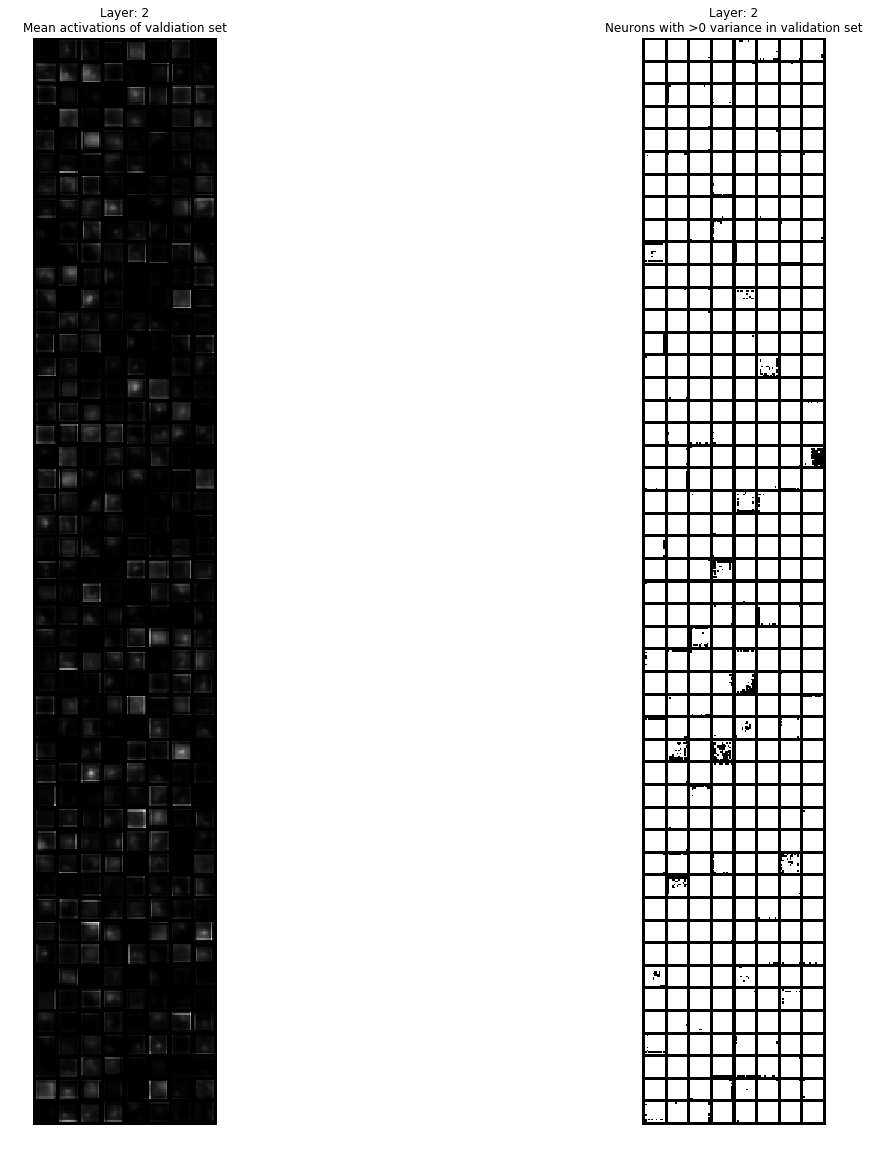

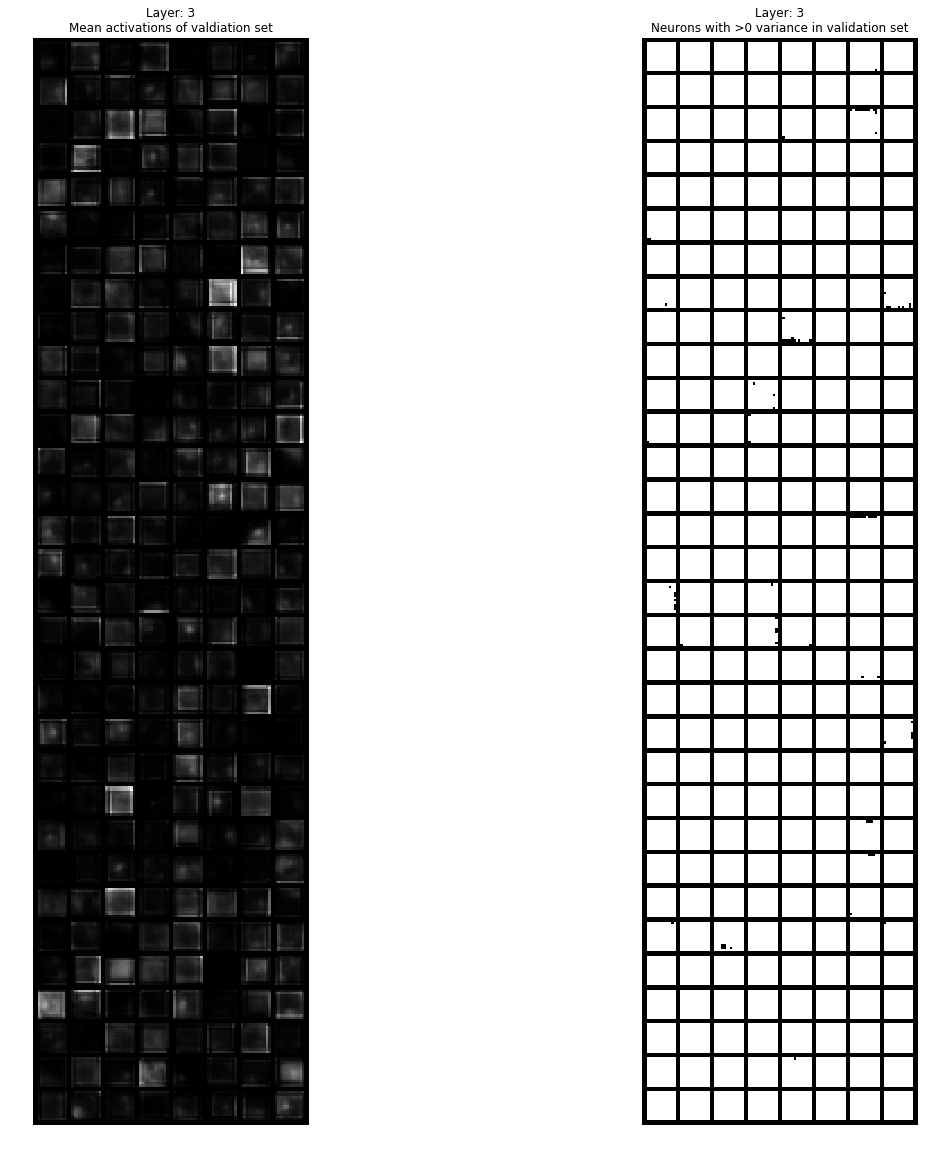

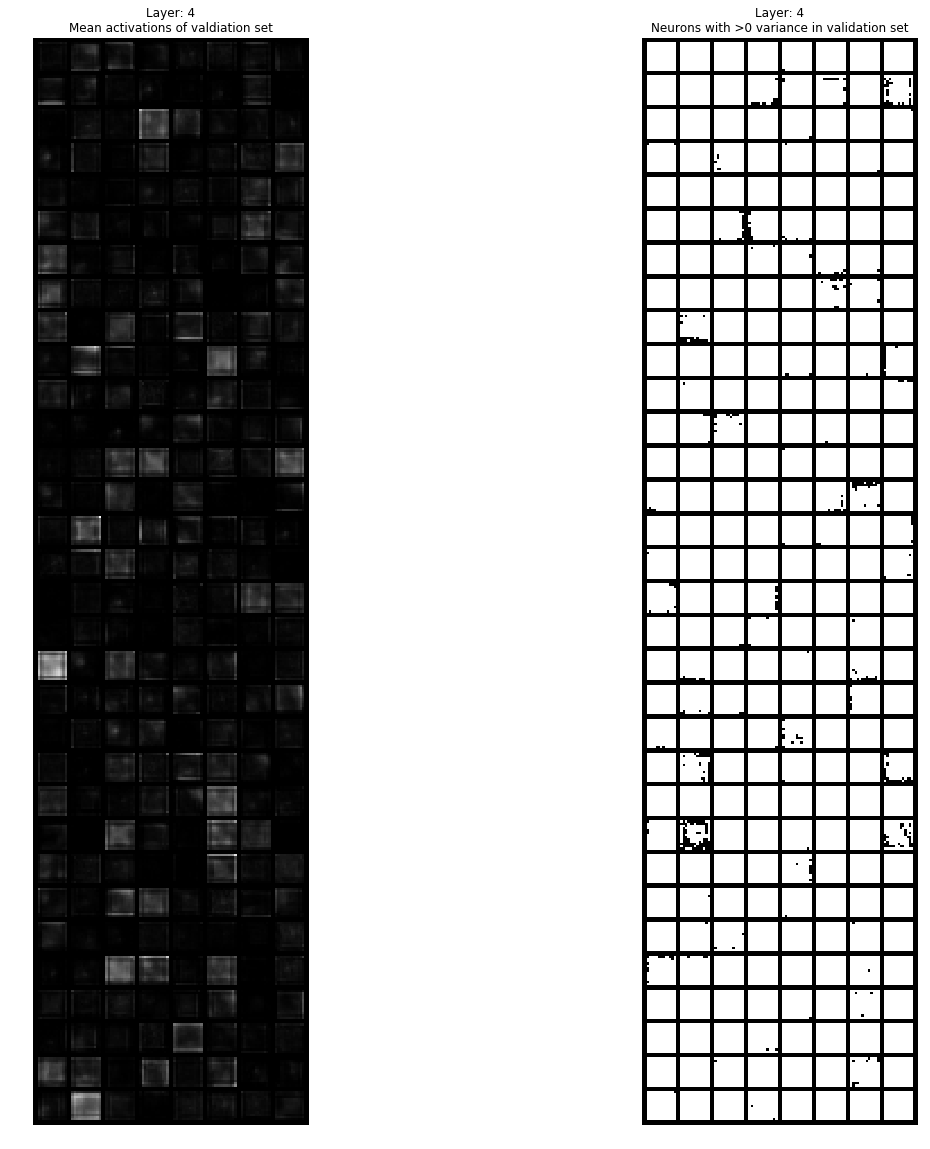

In [266]:
for l in selected.keys():
    im = make_grid(selected[l].squeeze(0).unsqueeze(1))
    mean_act_im = make_grid(mean_act_l[l].squeeze(0).unsqueeze(1))
    fig, ax = plt.subplots(1,2, figsize=(20, 20))
    ax[0].imshow(mean_act_im[0,], cmap='gray')
    ax[0].set_title("Layer: {}\nMean activations of valdiation set".format(l))
    ax[1].imshow(im[0,], cmap='gray')
    ax[1].set_title("Layer: {}\nNeurons with >0 variance in validation set".format(l))
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

### Let's do some machine learning on this

In [267]:
X.shape

(600, 484992)

In [230]:
def select_features(X, selected_support):
    return X[:, np.where(selected_support.numpy()[0,] == 1.)[0]]

In [231]:
X_s = select_features(X, selected_support)

In [232]:
X_s.shape

(600, 468441)

In [233]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = svm.SVC(C=10, kernel='linear', gamma="scale", verbose=5, probability=True)
# clf = GridSearchCV(clf, parameters,  n_jobs=4, verbose=5, cv=4)

In [234]:
clf.fit(X_s, Y)

[LibSVM]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=5)

THe thing is, we now have coefficients for 233181 features, but which features exactly? We need to map these features back into the original space of 484992 feature space. TO do that, we use the boolean vector generated in the first step of the pipeline

In [235]:
selected_support

tensor([[1., 1., 1.,  ..., 1., 1., 1.]])

In [236]:
selected_support.shape

torch.Size([1, 484992])

In [237]:
svm_selected_coeff = torch.zeros(selected_support.shape)

In [238]:
svm_selected_coeff.shape

torch.Size([1, 484992])

Do it!

In [239]:
svm_selected_coeff[0, np.where(selected_support[0] == 1.0)[0]] = torch.from_numpy(clf.coef_).float()

TEST

In [240]:
np.where(selected_support[0] == 1.0)[0]

array([     0,      1,      2, ..., 484989, 484990, 484991])

In [241]:
clf.coef_[0, -1]

-2.096664462791754e-06

In [243]:
svm_selected_coeff[0, 484991]

tensor(-2.0967e-06)

TEST ENDS HERE

### Visualize SVM coefficients

In [244]:
svm_selected_coeff_l, _s = recast_to_network_shape(svm_selected_coeff, 
                                                   shape_v, 
                                                   val_act, 
                                                   binary=True, 
                                                   layers=[0,1,2,3,4])

Flattened vector size = 193600 for original shape = torch.Size([64, 55, 55])
Referencing from 0 to 193600
Flattened vector size = 139968 for original shape = torch.Size([192, 27, 27])
Referencing from 193600 to 333568
Flattened vector size = 64896 for original shape = torch.Size([384, 13, 13])
Referencing from 333568 to 398464
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 398464 to 441728
Flattened vector size = 43264 for original shape = torch.Size([256, 13, 13])
Referencing from 441728 to 484992


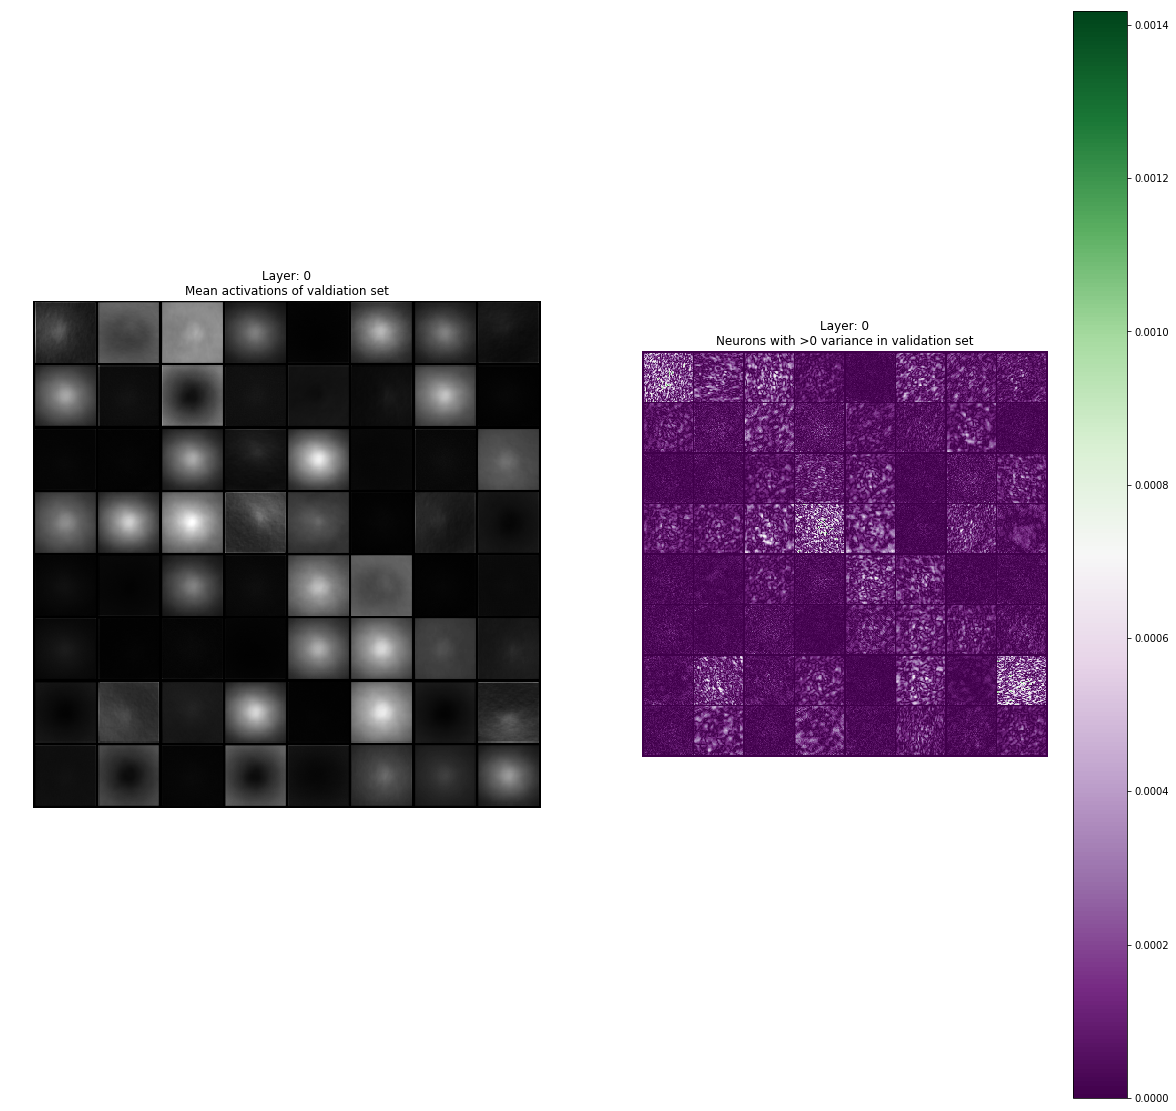

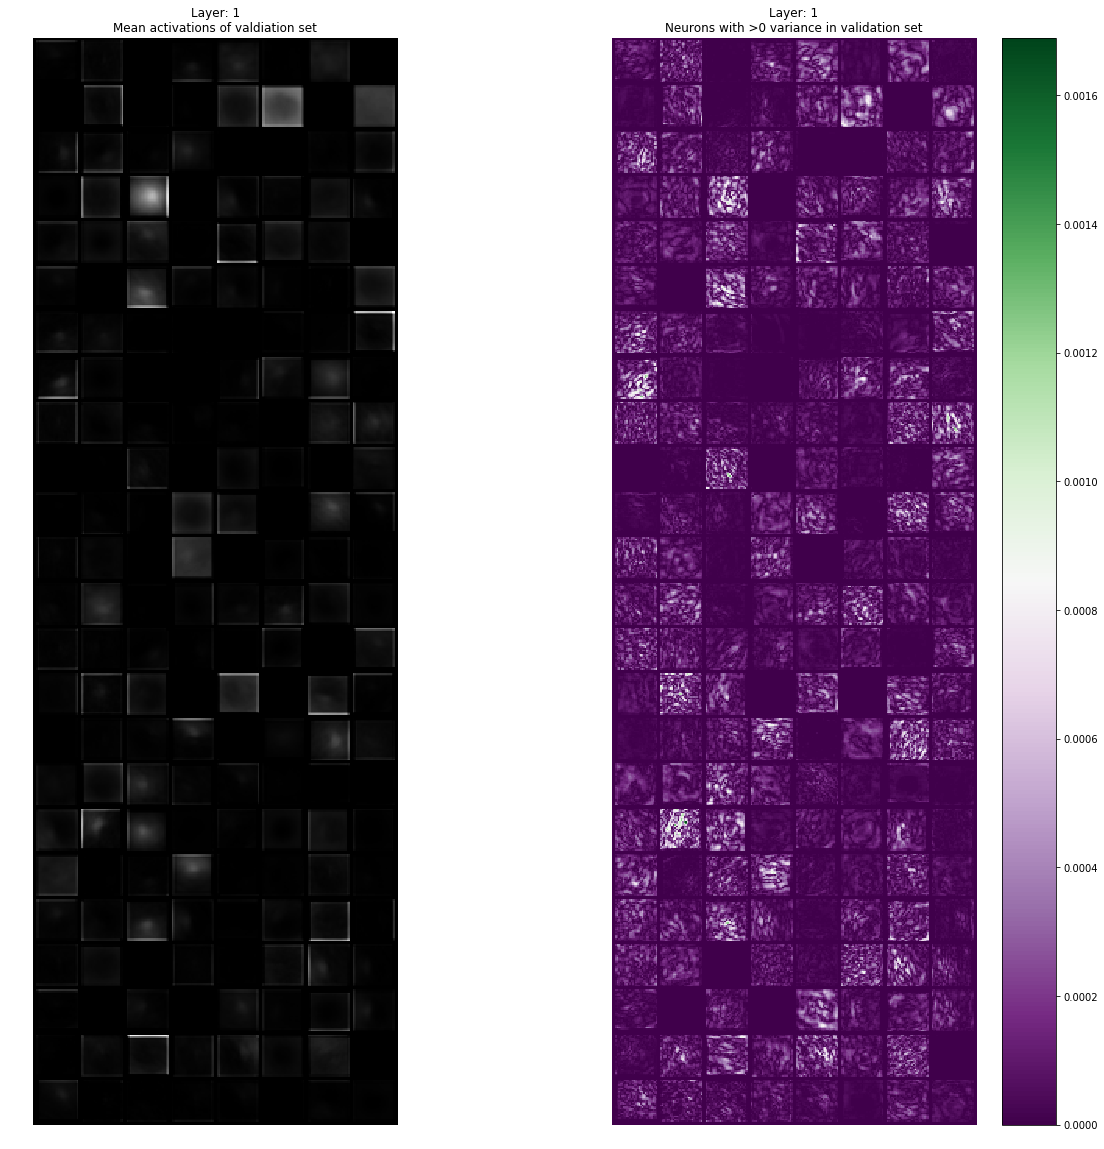

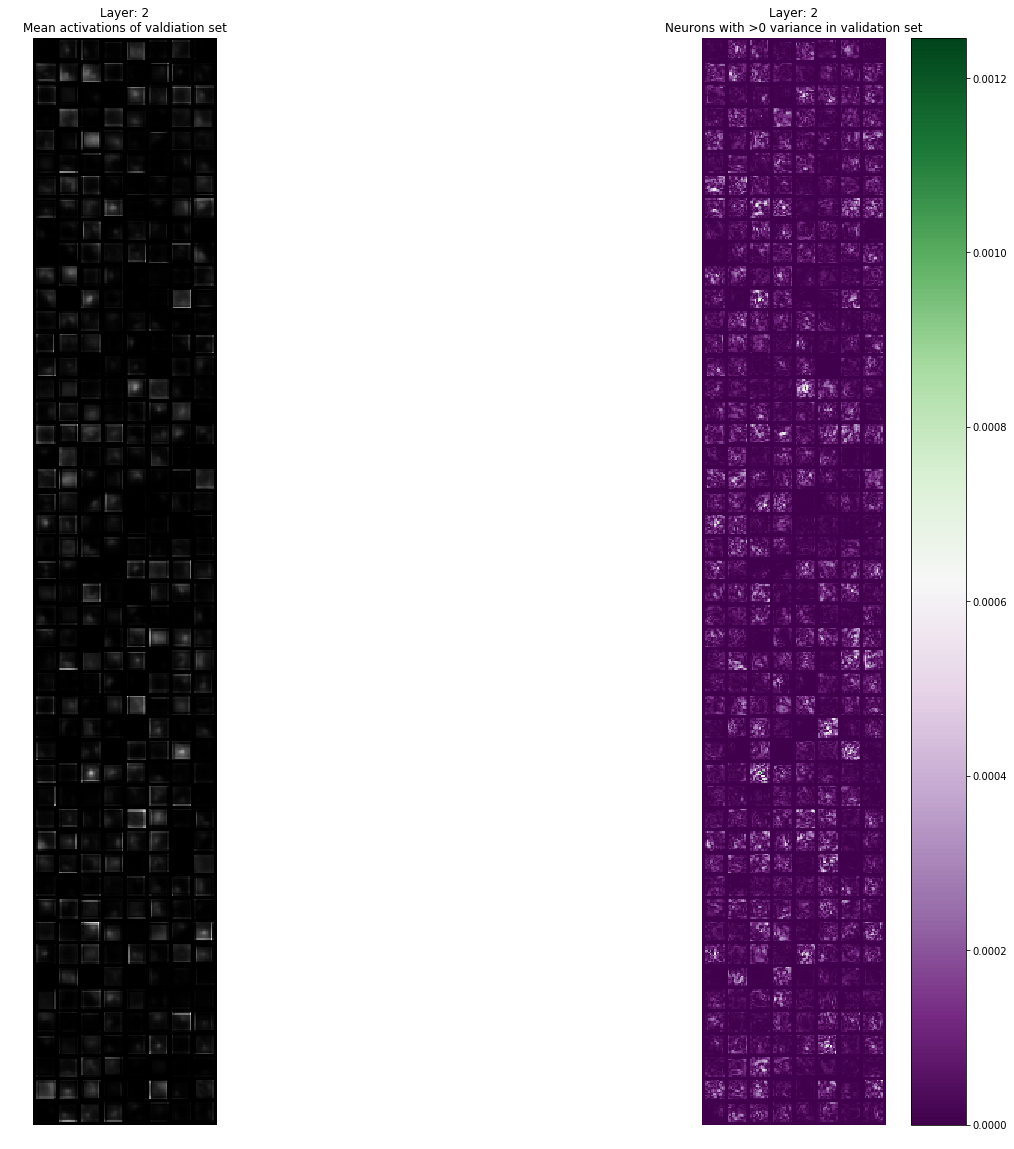

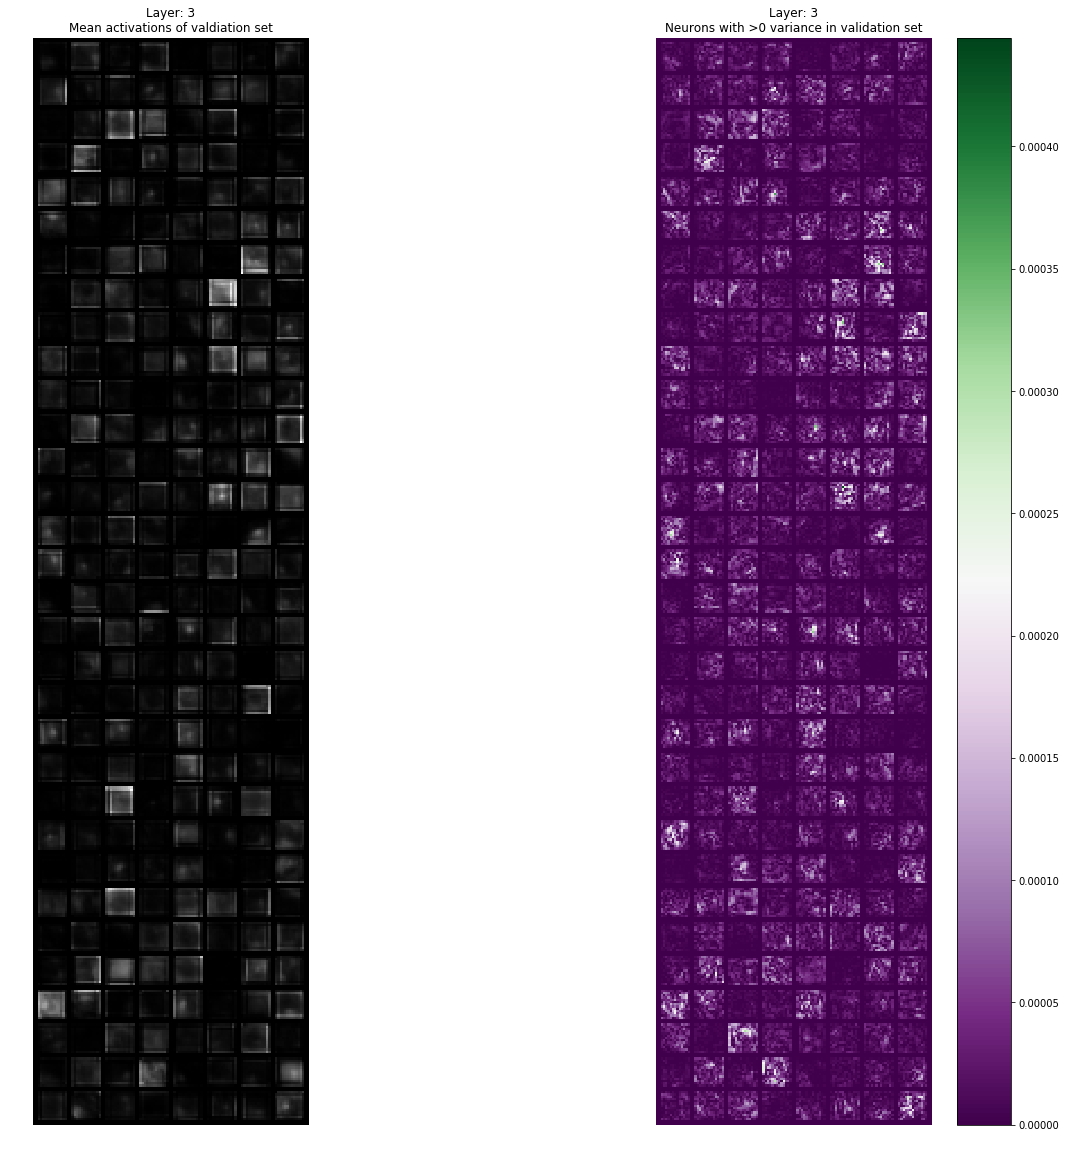

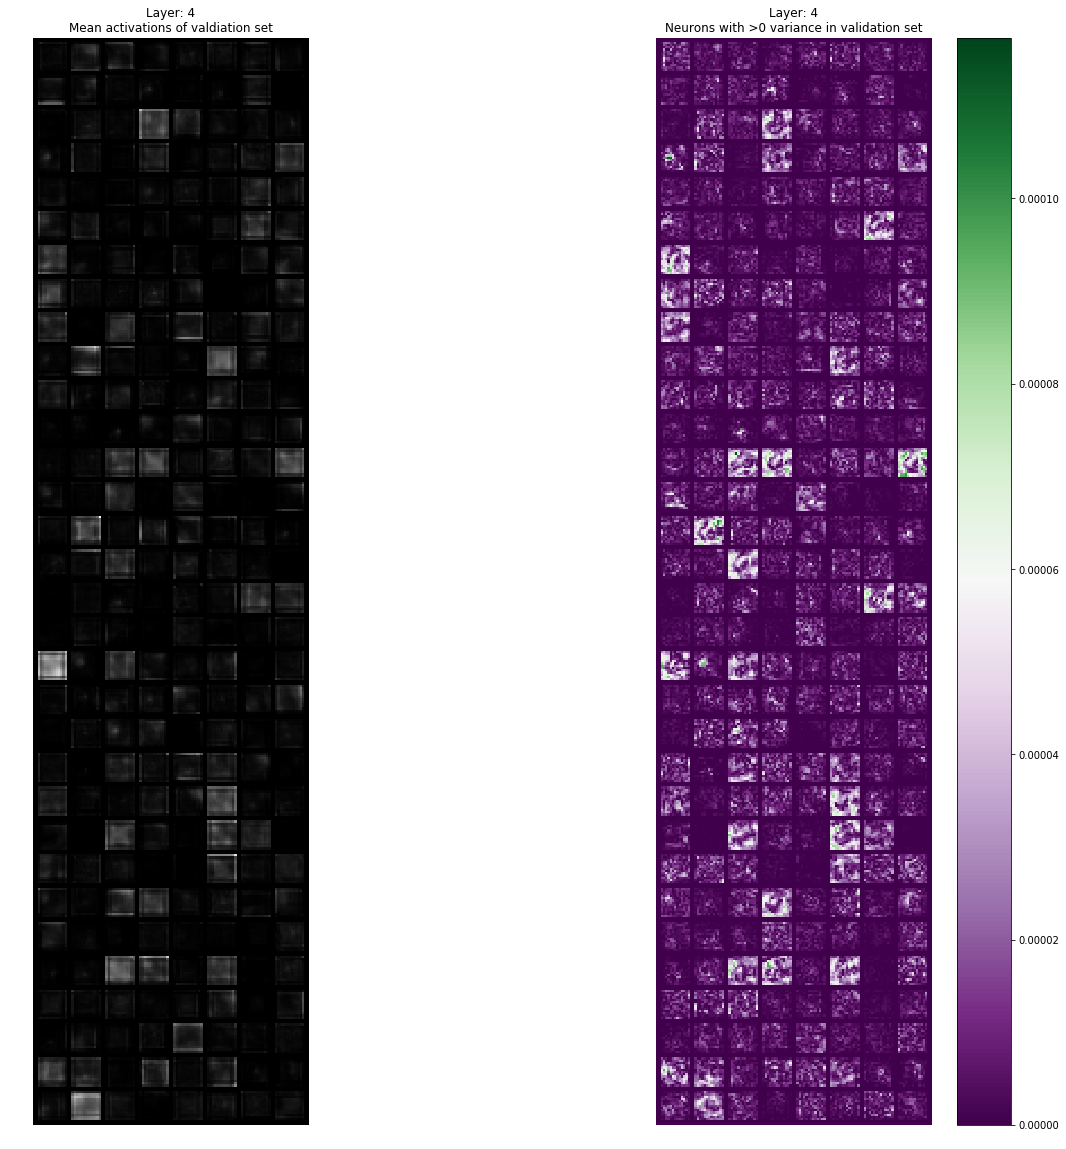

In [273]:
for l in selected.keys():
    im = make_grid(svm_selected_coeff_l[l].squeeze(0).unsqueeze(1))
    mean_act_im = make_grid(mean_act_l[l].squeeze(0).unsqueeze(1))
    fig, ax = plt.subplots(1,2, figsize=(20, 20))
    
    ax[0].imshow(mean_act_im[0,], cmap='gray')
    ax[0].set_title("Layer: {}\nMean activations of valdiation set".format(l))
    
    t = ax[1].imshow(np.abs(im[0,]), cmap='PRGn')
    ax[1].set_title("Layer: {}\nNeurons with >0 variance in validation set".format(l))
    ax[0].axis('off')
    ax[1].axis('off')
    plt.colorbar(t, ax=ax[1])
    plt.show()

### Filter out features using SVM's coefficients

In [278]:
svm_selected_coeff_l

torch.Size([1, 64, 55, 55])

### Mutual information idea

In [269]:
X_s.shape

(600, 468441)

In [270]:
Y.shape

(600,)

In [274]:
from sklearn.feature_selection import mutual_info_classif

In [275]:
mi = mutual_info_classif(X_s, Y, 
                  discrete_features='auto', 
                  n_neighbors=3, 
                  copy=True, 
                  random_state=None)

KeyboardInterrupt: 

Now let's test our trained model and see if it can figure out whether a query image was correctly or incorrectly classified

In [ ]:
q_im_act_matrix = recast_to_flattened(query_act, layers=[1,2,3])

In [ ]:
# query_act[0].shape[0]

In [ ]:
# q_im_act_matrix = torch.zeros([query_act[0].shape[0], 204864], dtype=torch.float32)

# for im in range(0, query_act[0].shape[0]):
#     for k in range(1, 3):
#         # 139968 + 64896
#         if k == 1:
#             q_im_act_matrix[im, 0:139968] = flatten(query_act[k][im,...])
#         elif k == 2:
#             q_im_act_matrix[im, 139968:] = flatten(query_act[k][im,...])

In [ ]:
q_im_act_matrix.shape

In [ ]:
gt_q.shape

In [ ]:
pred_q = softmax(pred_q)

In [ ]:
pred_q_pr, pred_q_cl = torch.max(pred_q, 1)

In [ ]:
new_gt_for_testing_q = torch.ones([pred_q.shape[0]], dtype=torch.int32)
correct = incorrect = 0
for i in range(0, pred_q.shape[0]):
    if pred_q_cl[i] != gt_q[i]:
        incorrect += 1
        new_gt_for_testing_q[i] = -1
    else:
        correct += 1
        new_gt_for_testing_q[i] = 1

In [ ]:
print("Correct predictions = {}, incorrect predictions = {}".format(correct, incorrect))

In [ ]:
X_test = q_im_act_matrix.numpy()
Y_test = new_gt_for_testing_q.numpy()

Time to test!

In [ ]:
clf.score(X_test, Y_test)

In [ ]:
proba_X_test = clf.predict_proba(X_test)

In [ ]:
proba_X_test

In [ ]:
gt_q

In [ ]:
import numpy as np

In [ ]:
x = np.array(range(0,  150))
plt.plot(x, pred_q.numpy()[:, 0], label='pr_0')
plt.plot(x, pred_q.numpy()[:, 1], label='pr_1')
plt.plot(x, proba_X_test[:, 0], label='pr_svm_0')
plt.plot(x, gt_q.numpy(), label='gt')
plt.legend()
plt.show()

In [ ]:
pred_q